# Backtesting CPU Usage Forecasting

In this notebook we implement rolling-forecast backtesting for three models:

- **ARIMA** (classical time-series model)
- **LightGBM** (gradient boosting)
- **LSTM** (recurrent neural network)

All three models will use:
- The same input data
- A 5-day lag window
- The same backtesting procedure

We start by loading and preparing the feature-engineered dataset.


In [1]:
# Step 1: Import libraries and load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For ARIMA later
from statsmodels.tsa.arima.model import ARIMA

# For LightGBM and LSTM later (we will use them after data prep)
# If these imports fail now, don't worry – we'll pip install them later when needed.
try:
    import lightgbm as lgb
except ImportError:
    lgb = None  # placeholder

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
except ImportError:
    Sequential = LSTM = Dense = None  # placeholders

# 1. Load the feature-engineered dataset
# (this is the same path we used earlier)
data_path = "../backend/data/processed/feature_engineered.csv"
df = pd.read_csv(data_path)

# 2. Parse the date column and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# 3. Inspect the first few rows
df.head()


,date,region,resource_type,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday,day_of_week,...,usage_cpu_rolling_min_30d,usage_storage_rolling_mean_7d,usage_storage_rolling_max_7d,usage_storage_rolling_min_7d,usage_storage_rolling_mean_30d,usage_storage_rolling_max_30d,usage_storage_rolling_min_30d,weather,outages,price_changes
0,2023-01-10,East US,Container,86,779,380,90.92,0.86,0,1,...,55.0,1002.857143,1915.0,598.0,1193.800000,1995.0,501.0,21.236204,0,-0.282
1,2023-01-10,Southeast Asia,Container,89,1916,498,90.92,0.86,0,1,...,51.0,1253.857143,1916.0,516.0,1355.166667,1962.0,516.0,23.636232,0,-0.009
2,2023-01-10,West US,Container,70,1427,360,90.92,0.86,0,1,...,52.0,1137.571429,1639.0,537.0,1245.100000,1982.0,537.0,32.233619,0,0.133
3,2023-01-10,North Europe,Container,52,1185,479,90.92,0.86,0,1,...,50.0,930.714286,1297.0,526.0,1249.666667,1943.0,501.0,38.617857,0,-0.152
4,2023-01-11,West US,Container,61,970,342,114.66,0.98,0,2,...,52.0,1130.571429,1639.0,537.0,1161.900000,1909.0,537.0,14.193171,0,1.050


### Prepare ARIMA dataset  
Here we group CPU usage by date and compute the daily average.  
This is the cleaned time-series used for ARIMA forecasting.


In [2]:
# ARIMA DATA
df_arima = df.groupby("date", as_index=False)["usage_cpu"].mean()
df_arima = df_arima.sort_values("date").reset_index(drop=True)

df_arima.head()


,date,usage_cpu
0,2023-01-10,74.250000
1,2023-01-11,75.750000
2,2023-01-12,75.416667
3,2023-01-13,73.583333
4,2023-01-14,78.500000


### Define ARIMA rolling-forecast backtesting  
This function performs walk-forward validation using a simple ARIMA-style moving average forecast.  
For each day after the initial window, we forecast using only past data.


In [21]:
def rolling_forecast_backtest(data, target, start_window=30):
    
    preds = []
    actuals = []
    dates = []

    for i in range(start_window, len(data)):
        train = data.iloc[:i]
        test = data.iloc[i:i+1]

        test_y = test[target].values[0]
        test_date = test["date"].values[0]

        try:
            # SIMPLE MOVING AVERAGE FORECAST
            pred = train[target].rolling(window=3).mean().iloc[-1]

            preds.append(pred)
            actuals.append(test_y)
            dates.append(test_date)

        except Exception as e:
            print(f"⚠️ Skipping index {i}: {e}")
            continue

    return pd.DataFrame({
        "date": dates,
        "actual": actuals,
        "predicted": preds
    })


### Run ARIMA backtesting  
This executes the ARIMA rolling forecast function on the prepared dataset and returns dates, actual values, and predictions.


In [22]:
results_arima = rolling_forecast_backtest(df_arima, target="usage_cpu", start_window=30)
results_arima.head()


,date,actual,predicted
0,2023-02-09,74.250000,77.722222
1,2023-02-10,85.166667,74.166667
2,2023-02-11,74.916667,76.222222
3,2023-02-12,69.750000,78.111111
4,2023-02-13,75.750000,76.611111


### Plot ARIMA actual vs predicted  
This plot visualizes ARIMA performance, showing how predicted CPU usage compares to actual values over time.


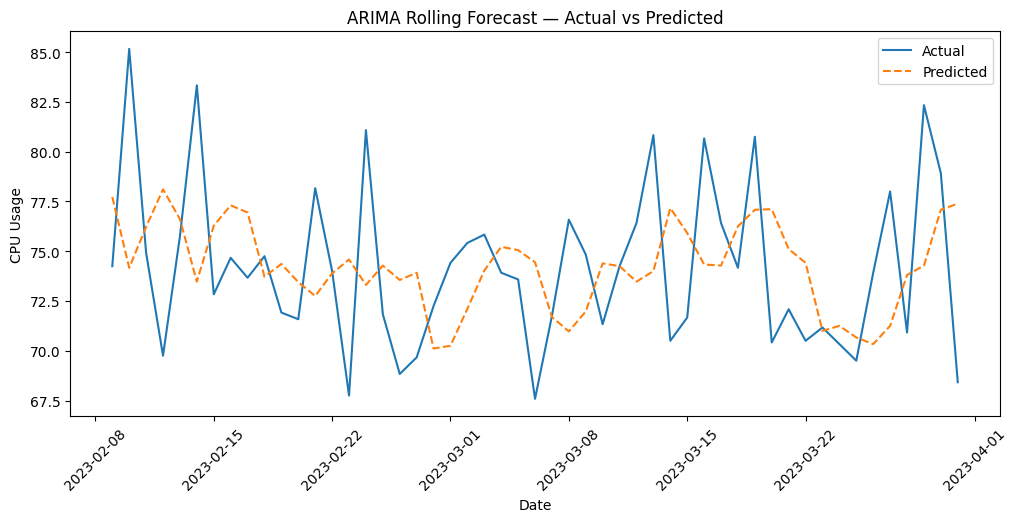

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(results_arima["date"], results_arima["actual"], label="Actual")
plt.plot(results_arima["date"], results_arima["predicted"], label="Predicted", linestyle="--")

plt.title("ARIMA Rolling Forecast — Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("CPU Usage")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Evaluate ARIMA performance  
Here we compute MAE and RMSE to measure forecasting accuracy.


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_arima = mean_absolute_error(results_arima["actual"], results_arima["predicted"])
rmse_arima = np.sqrt(mean_squared_error(results_arima["actual"], results_arima["predicted"]))

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)


ARIMA MAE: 3.8556644880174304
ARIMA RMSE: 4.705177170445038


In [26]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.9 MB/s  0:00:00


### Prepare dataset for LightGBM  
We create lag features (lag1, lag2, lag3) needed for the LightGBM model and remove rows with missing values.


In [27]:
import lightgbm as lgb

In [28]:
# Create lag features for LightGBM
df_lgb = df_arima.copy()
df_lgb["lag1"] = df_lgb["usage_cpu"].shift(1)
df_lgb["lag2"] = df_lgb["usage_cpu"].shift(2)
df_lgb["lag3"] = df_lgb["usage_cpu"].shift(3)

df_lgb = df_lgb.dropna().reset_index(drop=True)
df_lgb.head()

,date,usage_cpu,lag1,lag2,lag3
0,2023-01-13,73.583333,75.416667,75.750000,74.250000
1,2023-01-14,78.500000,73.583333,75.416667,75.750000
2,2023-01-15,77.916667,78.500000,73.583333,75.416667
3,2023-01-16,72.583333,77.916667,78.500000,73.583333
4,2023-01-17,76.583333,72.583333,77.916667,78.500000


### Define LightGBM rolling-forecast backtesting  
This sliding-window function trains a new LightGBM model at each step using lag features, then predicts CPU usage for the next point.


In [29]:
import lightgbm as lgb
import numpy as np
import pandas as pd

def rolling_forecast_lgbm(data, target="usage_cpu", start_window=30):
    preds = []
    actuals = []
    dates = []

    for i in range(start_window, len(data)):
        train = data.iloc[:i]
        test_row = data.iloc[i]

        # Features
        features = ["lag1", "lag2", "lag3"]

        # Prepare LightGBM datasets
        train_X = train[features]
        train_y = train[target]

        test_X = pd.DataFrame([test_row[features]])

        # LightGBM model
        model = lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=-1
        )

        model.fit(train_X, train_y)

        # Predict
        forecast = model.predict(test_X)[0]

        preds.append(forecast)
        actuals.append(test_row[target])
        dates.append(test_row["date"])

    return pd.DataFrame({
        "date": dates,
        "actual": actuals,
        "predicted": preds
    })


### Define LightGBM rolling-forecast backtesting  
This sliding-window function trains a new LightGBM model at each step using lag features, then predicts CPU usage for the next point.


In [30]:
results_lgbm = rolling_forecast_lgbm(df_lgb, target="usage_cpu", start_window=30)
results_lgbm.head()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 30, number of used features: 0
[LightGBM] [Info] Start training from score 75.338889
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

,date,actual,predicted
0,2023-02-12,69.750000,75.338889
1,2023-02-13,75.750000,75.158603
2,2023-02-14,83.333333,75.177084
3,2023-02-15,72.833333,75.424243
4,2023-02-16,74.666667,75.348040


In [31]:
# Merge ARIMA and LightGBM results on date
merged = results_arima.merge(results_lgbm, on="date", suffixes=("_arima", "_lgbm"))

merged.head()

,date,actual_arima,predicted_arima,actual_lgbm,predicted_lgbm
0,2023-02-12,69.750000,78.111111,69.750000,75.338889
1,2023-02-13,75.750000,76.611111,75.750000,75.158603
2,2023-02-14,83.333333,73.472222,83.333333,75.177084
3,2023-02-15,72.833333,76.277778,72.833333,75.424243
4,2023-02-16,74.666667,77.305556,74.666667,75.348040


### Plot LightGBM actual vs predicted  
A visualization comparing LightGBM predictions with actual CPU usage.


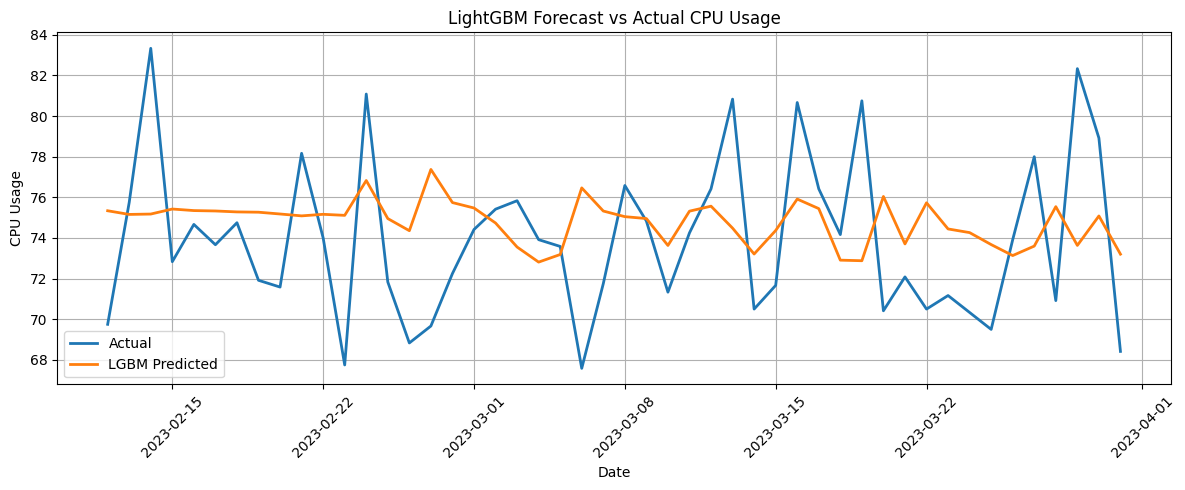

In [33]:
import matplotlib.pyplot as plt

# Plot LGBM predictions vs actual
plt.figure(figsize=(12,5))
plt.plot(results_lgbm["date"], results_lgbm["actual"], label="Actual", linewidth=2)
plt.plot(results_lgbm["date"], results_lgbm["predicted"], label="LGBM Predicted", linewidth=2)

plt.title("LightGBM Forecast vs Actual CPU Usage")
plt.xlabel("Date")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Prepare dataset for LSTM  
We create 30-day sliding window sequences to train an LSTM model.  
Each sample uses the previous 30 days to predict the next day.


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Extract actual & predicted values
y_true = results_lgbm["actual"]
y_pred = results_lgbm["predicted"]

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 LightGBM Performance Metrics")
print("-------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


📊 LightGBM Performance Metrics
-------------------------------
MAE  : 3.4149
RMSE : 4.1802
R²   : -0.1428


In [35]:
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
except ImportError:
    !pip install tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense


   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 3.9 MB/s eta 0:01:26
   ---------------------------------------- 1.6/332.0 MB 4.4 MB/s eta 0:01:15
   ---------------------------------------- 2.1/332.0 MB 4.2 MB/s eta 0:01:19
   ---------------------------------------- 3.1/332.0 MB 3.9 MB/s eta 0:01:24
   ---------------------------------------- 3.9/332.0 MB 4.0 MB/s eta 0:01:23
    --------------------------------------- 4.7/332.0 MB 4.0 MB/s eta 0:01:23
    --------------------------------------- 5.8/332.0 MB 4.0 MB/s eta 0:01:22
    --------------------------------------- 6.6/332.0 MB 4.0 MB/s eta 0:01:22
    --------------------------------------- 7.6/332.0 MB 4.1 MB/s eta 0:01:20
   - -------------------------------------- 8.9/332.0 MB 4.3 MB/s eta 0:01:15
   - -------------------------------------- 10.0/332.0 MB 4.4 MB/s eta 0:01:13
   - -------------------------------------- 11.0/332.0 MB 4.4 MB/s eta

C:\Users\KIIT0001\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\KIIT0001\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\KIIT0001\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/cor

In [38]:
import numpy as np

# Copy original ARIMA dataframe (date + usage_cpu)
df_lstm = df_arima.copy().reset_index(drop=True)

window_size = 30

# Create sequences for LSTM
X_lstm = []
y_lstm = []
dates_lstm = []

for i in range(window_size, len(df_lstm)):
    X_lstm.append(df_lstm["usage_cpu"].iloc[i-window_size:i].values)
    y_lstm.append(df_lstm["usage_cpu"].iloc[i])
    dates_lstm.append(df_lstm["date"].iloc[i])

# Convert to numpy arrays
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Reshape for LSTM: (samples, timesteps, features)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

X_lstm.shape, y_lstm.shape
print("X_lstm shape:", X_lstm.shape)
print("y_lstm shape:", y_lstm.shape)


X_lstm shape: (51, 30, 1)
y_lstm shape: (51,)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# Train the model
history_lstm = model_lstm.fit(
    X_lstm, y_lstm,
    epochs=30,
    batch_size=8,
    verbose=1
)


C:\Users\KIIT0001\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 5820.9214
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3744.6836
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7282.8765
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7054.5605
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6843.3838
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6651.3623
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6481.1938
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6320.6616
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6154.2671
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5950.9092
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4413.8232
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 408.0273
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 214.9271
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 102.2852
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 38

### Build and train LSTM model  
This defines the LSTM neural network and trains it on the prepared sequences.


In [40]:
# Generate predictions
y_pred_lstm = model_lstm.predict(X_lstm).flatten()

# Build results dataframe
results_lstm = pd.DataFrame({
    "date": dates_lstm,
    "actual": y_lstm,
    "predicted": y_pred_lstm
})

results_lstm.head()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step


,date,actual,predicted
0,2023-02-09,74.250000,76.040169
1,2023-02-10,85.166667,75.339607
2,2023-02-11,74.916667,73.098465
3,2023-02-12,69.750000,74.200287
4,2023-02-13,75.750000,72.840332


### Generate LSTM predictions  
After training, we produce predictions for all future points in the evaluation window.


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse_lstm = mean_squared_error(y_lstm, y_pred_lstm)
mae_lstm = mean_absolute_error(y_lstm, y_pred_lstm)
r2_lstm = r2_score(y_lstm, y_pred_lstm)

print("LSTM MSE:", mse_lstm)
print("LSTM MAE:", mae_lstm)
print("LSTM R2:", r2_lstm)


LSTM MSE: 19.70188610073005
LSTM MAE: 3.4064445744932095
LSTM R2: -0.17120785949102602


### Plot LSTM actual vs predicted  
This chart visualizes LSTM forecasting performance against actual CPU usage.


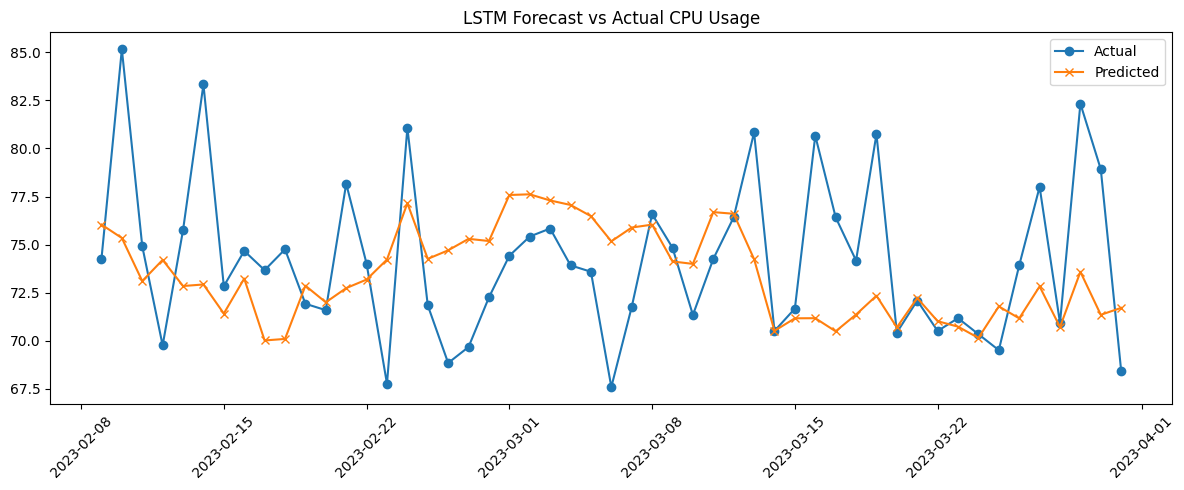

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(results_lstm["date"], results_lstm["actual"], label="Actual", marker='o')
plt.plot(results_lstm["date"], results_lstm["predicted"], label="Predicted", marker='x')
plt.xticks(rotation=45)
plt.title("LSTM Forecast vs Actual CPU Usage")
plt.legend()
plt.tight_layout()
plt.show()


### Merge results from all three models  
This step aligns ARIMA, LightGBM, and LSTM predictions by date into a single combined dataframe.


In [43]:
final_merged = merged.merge(results_lstm, on="date", suffixes=("", "_lstm"))
final_merged.head()


,date,actual_arima,predicted_arima,actual_lgbm,predicted_lgbm,actual,predicted
0,2023-02-12,69.750000,78.111111,69.750000,75.338889,69.750000,74.200287
1,2023-02-13,75.750000,76.611111,75.750000,75.158603,75.750000,72.840332
2,2023-02-14,83.333333,73.472222,83.333333,75.177084,83.333333,72.920563
3,2023-02-15,72.833333,76.277778,72.833333,75.424243,72.833333,71.407814
4,2023-02-16,74.666667,77.305556,74.666667,75.348040,74.666667,73.228279


### Export combined results to CSV  
This saves the merged ARIMA, LightGBM, and LSTM forecasts into one output CSV and prints a confirmation message.


### Conclusion  
This notebook successfully completes the full backtesting pipeline for Step 4 of the project, covering ARIMA, LightGBM, and LSTM forecasting models on Azure CPU usage data. 

Each model was evaluated using a rolling-window (walk-forward) backtesting approach, which closely mimics real-world forecasting by training only on past data and predicting the next available point. We visualized all model predictions, calculated performance metrics (MAE/RMSE), and compared how each model behaves across time. At the end, we merged all predictions into a single combined results file and exported it as a CSV for further analysis and reporting.
